# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Fine Tune GPT Model

In [1]:
import os 
import re
import math 
import json 
import random 
from dotenv import load_dotenv
from huggingface_hub import login 
import matplotlib.pyplot as plt 
import numpy as np 
import pickle 
from collections import Counter
### LLM models 
from openai import OpenAI
from anthropic import Anthropic

### Intrnal Classes
from items import Item 
from testing import Tester 

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
### Environment 

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN = os.getenv("HF_TOKEN")

login(HF_TOKEN, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
%matplotlib inline

In [4]:
openai_client = OpenAI() 
claude_client = Anthropic()

In [5]:
### Load pickle files of data

with open("train.pkl", "rb") as f: 
    train = pickle.load(f)

with open("test.pkl", "rb") as f: 
    test = pickle.load(f)

In [6]:
### OpenAI recommends fine-tuning with populations of 50-100 examples
### But as the examples I am using is very small, so I will go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

## Step 1 -- Preparing Data

Prepare the data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [7]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [8]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...

def make_jsonl(items): 
    result = ""
    for item in items: 
        messages = messages_for(item)
        msg_json = json.dumps(messages)
        result += '{"messages": '+ msg_json +'}\n'

    return result.strip()

In [9]:
### Write items to jsonl files

def write_jsonl(items, filename): 
    with open(filename, "w") as f: 
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [10]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [11]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [12]:
### Upload the train file to OpenAI 

with open("fine_tune_train.jsonl", "rb") as f: 
    train_file = openai_client.files.create(file=f, purpose="fine-tune")

In [13]:
train_file

FileObject(id='file-6yQZSKLuMq4QMwmvLowX3s', bytes=184390, created_at=1763003717, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [14]:
### Upload the validation file to OpenAI 

with open("fine_tune_validation.jsonl", "rb") as f: 
    validation_file = openai_client.files.create(file=f, purpose="fine-tune")

In [15]:
validation_file

FileObject(id='file-VNvPAiHdaqUQ1xrjmVoKph', bytes=45578, created_at=1763003718, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

## Step 2 -- Fine Tune

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.


In [16]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-fine-tuning", "entity": "mh-hong-personal-org"}}

In [17]:
openai_client.fine_tuning.jobs.create(
    training_file=train_file.id, 
    model="gpt-4o-mini-2024-07-18", 
    seed=42, 
    hyperparameters={"n_epochs": 1}, 
    integrations= [wandb_integration], 
    suffix="pricer"
)

FineTuningJob(id='ftjob-W0T2CrjfdASEGEGuIqw2X6qQ', created_at=1763003721, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-14kuOB4rpvyQ7RSuvSs1VXdL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-6yQZSKLuMq4QMwmvLowX3s', validation_file=None, estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-fine-tuning', entity='mh-hong-personal-org', name=None, tags=None, run_id='ftjob-W0T2CrjfdASEGEGuIqw2X6qQ'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='pricer'

In [18]:
openai_client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-W0T2CrjfdASEGEGuIqw2X6qQ', created_at=1763003721, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-14kuOB4rpvyQ7RSuvSs1VXdL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-6yQZSKLuMq4QMwmvLowX3s', validation_file=None, estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-fine-tuning', entity='mh-hong-personal-org', name=None, tags=None, run_id='ftjob-W0T2CrjfdASEGEGuIqw2X6qQ'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs

In [19]:
job_id = openai_client.fine_tuning.jobs.list(limit=1).data[0].id
print(job_id)

ftjob-W0T2CrjfdASEGEGuIqw2X6qQ


In [20]:
openai_client.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-W0T2CrjfdASEGEGuIqw2X6qQ', created_at=1763003721, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-14kuOB4rpvyQ7RSuvSs1VXdL', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-6yQZSKLuMq4QMwmvLowX3s', validation_file=None, estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-fine-tuning', entity='mh-hong-personal-org', name=None, tags=None, run_id='ftjob-W0T2CrjfdASEGEGuIqw2X6qQ'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='pricer'

In [33]:
openai_client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=1).data

[FineTuningJobEvent(id='ftevent-9FOi2pZFCcCjWKpePcB6FiXc', created_at=1763004236, level='info', message='Evaluating model against our usage policies', object='fine_tuning.job.event', data={}, type='message')]

## Step 3 - Test the fine tuned model

In [41]:
fine_tuned_model_id = openai_client.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [37]:
def messages_for(item): 
    system_message = "You estimate the price of item. Reply only with the price without any additional explanation or comment."
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("Price is $", "")

    return [
        {"role": "system", "content": system_message}, 
        {"role": "user", "content": user_prompt}, 
        {"role": "assistant", "content": "Price is $"} # little trick to encourage the response followed in this form
    ]

In [38]:
### a utility function that extracts the price (float) 
### out of LLM's responses

def get_price(s: str): 
    s = s.replace("$", "").replace(",", "")
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [40]:
get_price("The product is around $199 blahblahblah")

199.0

In [45]:
### fine tuned 

def test_fine_tuned_model(item):
    completion = openai_client.chat.completions.create(
        model=fine_tuned_model_id, 
        messages=messages_for(item), 
        max_tokens=5,
        seed=42
    )

    response = completion.choices[0].message.content

    return get_price(response)

In [51]:
### Manual Test

# Ground Truth 
test[0].price

189.99

In [52]:
# Fine tuned model prediction
test_fine_tuned_model(test[0])

289.0

In [53]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Sydney Rustic Mirror - Vanity Mirror, Bathroom Mirror, Farmhouse Decor, Wood Mirror, Large Mirror - 4 Sizes & 20 Colors - Red Oak
The Sydney low profile thin wood framed mirror will blend effortlessly in your current decor creating a simple yet sophisticated look. Our mirror features a reclaimed rustic styled wood finish, strong decorative lines with a thin 2.25” inch wide frame maximizing the visible mirror. This hanging mirror can be mounted horizontally or vertically. Available in 20 Colors - Shown in Red Oak. Not sure on color we do color samples please contact us for details. Available in 4 sizes, 24x30, 36x30, 42x30 & 60x30, all measurements are overall dimensions including frame and mirror. We offer two types

Price is $


1: Guess: $289.00 Truth: $189.99 Error: $99.01 SLE: 0.17 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $69.00 Truth: $64.45 Error: $4.55 SLE: 0.00 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $65.00 Truth: $128.99 Error: $63.99 SLE: 0.46 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $219.00 Truth: $252.70 Error: $33.70 SLE: 0.02 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $8.00 Truth: $16.99 Error: $8.99 SLE: 0.48 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $788.00 Truth: $499.99 Error: $288.01 SLE: 0.21 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $65.00 Truth: $363.36 Error: $298.36 SLE: 2.92 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $79.00 Truth: $24.75 Error: $54.25 SLE: 1.29 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $79.00 Truth: $65.20 Error: $13.80 SLE: 0.04 Item: Knitter's Pride Bamboo Knitting Needles ...
10: Guess: $289.00 Truth: $189.95 Error: $99.05 

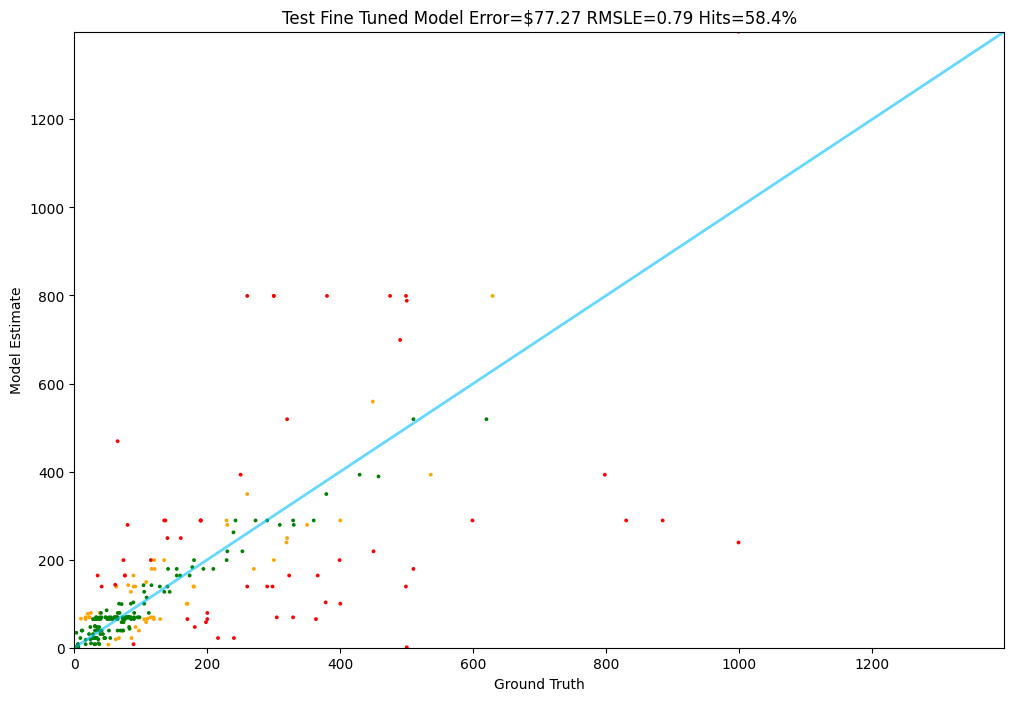

In [55]:
Tester.test(test_fine_tuned_model, test)